# Survival Analysis with Neural Networks
This notebook demonstrates a complete workflow for survival analysis using a custom multi-task neural network model. The notebook covers data preparation, model definition, training, and evaluation.

# Data Preparation

## installing the necessary libraries.

In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 6.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=0884b47f09eb7d69c5ce6c48c1bbfca4ea80515c315acf7fc24989a0446a41a9
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
!pip install scikit-learn==1.0.2
!pip install scikit-survival

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 21.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.13.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 63.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [ ]:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sksurv.metrics import concordance_index_censored
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from lifelines import KaplanMeierFitter


## Loading the dataset from an Excel file and performing necessary preprocessing

In [ ]:

data = pd.read_excel('4A_TB_cleaned.xlsx')

# function to calculate the survival status
def calculate_survival_status(row):
    if row['OUT COME'] == 'DIED':
        return 1
    else:
        return 0


data['SURVIVAL'] = data.apply(calculate_survival_status, axis=1)

data.drop(columns=['UNIT','DISTRICT OF RESIDENCE','WORKING DIAGNOSIS','ADDITIONAL WORKING DIAGNOSIS',
                   'MARITAL STATUS', 'IP NUMBER', 'OUT COME'], inplace=True)

new_col_order = ['SEX', 'AGE', 'RELIGION', 'REGION', 'NUMBER OF ADDITIONAL WORKING DIAGNOSIS', 'TB_type',
                 'NUMBER OF PREVIOUS ADMISSIONS', 'DAY OF ADMISSION', 'MONTH OF ADMISSION',
                 'YEAR OF ADMISSION', 'DURATION', 'SURVIVAL']
data = data[new_col_order]

data.dropna(subset=['SURVIVAL'], inplace=True)
data.reset_index(drop=True, inplace=True)
data['SURVIVAL'] = data['SURVIVAL'].astype(int)

data.shape

(16368, 12)

In [ ]:
data.head()

,SEX,AGE,RELIGION,REGION,NUMBER OF ADDITIONAL WORKING DIAGNOSIS,TB_type,NUMBER OF PREVIOUS ADMISSIONS,DAY OF ADMISSION,MONTH OF ADMISSION,YEAR OF ADMISSION,DURATION,SURVIVAL
0,M,30,COU,CENTRAL,1,Abdominal_TB,5,Tuesday,November,2010,6,0
1,M,30,COU,CENTRAL,1,Abdominal_TB,5,Tuesday,November,2010,6,0
2,M,30,COU,CENTRAL,1,Abdominal_TB,5,Tuesday,November,2010,6,0
3,M,30,COU,CENTRAL,1,Abdominal_TB,5,Tuesday,November,2010,6,0
4,F,46,COU,CENTRAL,1,Disseminated TB,3,Monday,December,2010,4,0


In [ ]:
data.isnull().sum()


,0
SEX,0
AGE,0
RELIGION,0
REGION,0
NUMBER OF ADDITIONAL WORKING DIAGNOSIS,0
TB_type,0
NUMBER OF PREVIOUS ADMISSIONS,0
DAY OF ADMISSION,0
MONTH OF ADMISSION,0
YEAR OF ADMISSION,0


## Encoding Categorical Features and Standardizing Continuous Features

In [ ]:


# dictionary for month encoding
month_mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
                 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

# dictionary for day of week encoding
day_mapping = {'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday':76 }

data['Month of Admission'] = data['MONTH OF ADMISSION'].map(month_mapping)
data['Day of Admission'] = data['DAY OF ADMISSION'].map(day_mapping)

data.drop(columns=['MONTH OF ADMISSION', 'DAY OF ADMISSION'], inplace=True)



categorical_features = ['SEX', 'RELIGION', 'REGION', 'TB_type']

dataset = pd.get_dummies(data, columns=categorical_features)
dataset = dataset.astype(int)
dataset.head()

#Standardizing continuous features
standardize_features = ['AGE','NUMBER OF PREVIOUS ADMISSIONS','NUMBER OF ADDITIONAL WORKING DIAGNOSIS', 'DURATION', 'Month of Admission', 'Day of Admission']
scaler = StandardScaler()
dataset[standardize_features] = scaler.fit_transform(dataset[standardize_features])
dataset.head()

,AGE,NUMBER OF ADDITIONAL WORKING DIAGNOSIS,NUMBER OF PREVIOUS ADMISSIONS,YEAR OF ADMISSION,DURATION,SURVIVAL,Month of Admission,Day of Admission,SEX_F,SEX_M,...,REGION_EASTERN,REGION_NORTHERN,REGION_UNKNOWN,REGION_WESTERN,TB_type_Abdominal_TB,TB_type_CNS_TB,TB_type_Disseminated TB,TB_type_Other TBs,TB_type_PTB,TB_type_TB iris
0,-0.476431,-0.700413,0.829420,2010,-0.302662,0,1.335036,-0.368800,0,1,...,0,0,0,0,1,0,0,0,0,0
1,-0.476431,-0.700413,0.829420,2010,-0.302662,0,1.335036,-0.368800,0,1,...,0,0,0,0,1,0,0,0,0,0
2,-0.476431,-0.700413,0.829420,2010,-0.302662,0,1.335036,-0.368800,0,1,...,0,0,0,0,1,0,0,0,0,0
3,-0.476431,-0.700413,0.829420,2010,-0.302662,0,1.335036,-0.368800,0,1,...,0,0,0,0,1,0,0,0,0,0
4,1.010431,-0.700413,0.353972,2010,-0.559238,0,1.626162,-0.413998,1,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:

dataset['SURVIVAL'].value_counts()


,count
SURVIVAL,
0,11124
1,5244


## Splitting Data and Converting Data to TensorFlow Dataset


In [ ]:

dataset['YEAR OF ADMISSION'].value_counts()

test_data = dataset[dataset['YEAR OF ADMISSION'] >= 2018].copy()
train_data = dataset[dataset['YEAR OF ADMISSION'] < 2018].copy()

test_data.drop(columns=['YEAR OF ADMISSION'], inplace=True)
train_data.drop(columns=['YEAR OF ADMISSION'], inplace=True)
dataset.drop(columns=['YEAR OF ADMISSION'], inplace=True)


def to_tf_dataset(data, features, target, task_col, batch_size=64):
    def generator():
        for _, row in data.iterrows():
            x = row[features].values.astype(np.float32)
            y = row[target].astype(np.float32)
            task = row[task_col].astype(np.int32) - 1
            yield x, y, task

    output_signature = (
        tf.TensorSpec(shape=(len(features),), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    return tf.data.Dataset.from_generator(generator, output_signature=output_signature).batch(batch_size).shuffle(buffer_size=1024)

X = [col for col in dataset.columns if col not in ['SURVIVAL', 'WEEK', 'DURATION']]
E = 'SURVIVAL'
T = 'DURATION'

train_dataset = to_tf_dataset(train_data, X, E, T)
test_dataset = to_tf_dataset(test_data, X, E, T)

In [ ]:
train_data.shape

(13068, 25)

In [ ]:
test_data.shape

(3300, 25)

# **Model Training**

## Define the Multi-Task Model
A BaseMultiTaskModel class for our survival analysis is difined.

***Proposed model***

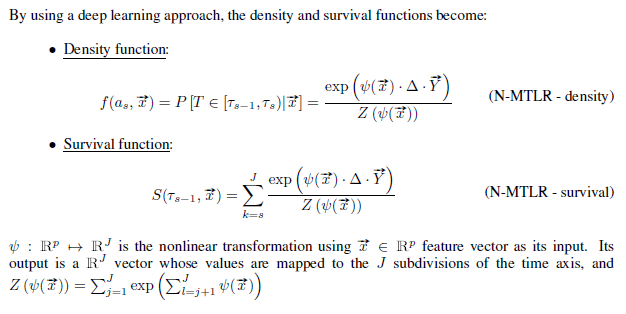





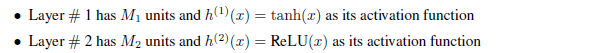


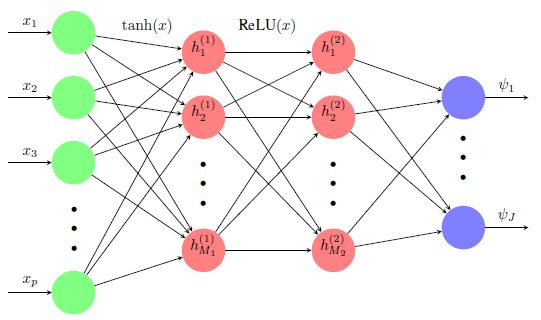

In [ ]:
class BaseMultiTaskModel:
    def __init__(self, structure, bins=100, auto_scaler=True, dropout_rate=0.5, l2_lambda=0.01, initializer='glorot_uniform'):
        self.structure = structure
        self.bins = bins
        self.auto_scaler = auto_scaler
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        self.scaler = StandardScaler() if auto_scaler else None
        self.model = None
        self.loss_values = []
        self.val_loss_values = []
        self.initializer = initializer

    def get_initializer(self):
        if self.initializer == 'glorot_uniform':
            return GlorotUniform()
        elif self.initializer == 'glorot_normal':
            return GlorotNormal()
        else:
            raise ValueError("Initializer not supported. Choose either 'glorot_uniform' or 'glorot_normal'.")

    def get_times(self, T, is_min_time_zero=True, extra_pct_time=0.1):
        max_time = np.max(T)
        min_time = 0. if is_min_time_zero else np.min(T)
        p = extra_pct_time if 0. <= extra_pct_time <= 1. else 0.1

        self.times = np.linspace(min_time, max_time * (1. + p), self.bins)
        self.time_buckets = [(self.times[i], self.times[i + 1]) for i in range(len(self.times) - 1)]
        self.num_times = len(self.time_buckets)

    def compute_XY(self, X, T, E, is_min_time_zero, extra_pct_time):
        self.get_times(T, is_min_time_zero, extra_pct_time)
        n_units = T.shape[0]

        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []

        for i, (t, e) in enumerate(zip(T, E)):
            y = np.zeros(self.num_times + 1)
            min_abs_value = [abs(a_j_1 - t) for (a_j_1, a_j) in self.time_buckets]
            index = np.argmin(min_abs_value)

            if e == 1:
                y[index] = 1.
                X_uncens.append(X[i, :].tolist())
                Y_uncens.append(y.tolist())
            else:
                y[index:] = 1.
                X_cens.append(X[i, :].tolist())
                Y_cens.append(y.tolist())

        return np.array(X_cens), np.array(X_uncens), np.array(Y_cens), np.array(Y_uncens)

    def build_model(self, input_shape):
        initializer = self.get_initializer()

        inputs = Input(shape=(input_shape,))
        x = inputs
        for layer in self.structure:
            x = Dense(units=layer['num_units'], activation=layer['activation'],
                      kernel_regularizer=l2(self.l2_lambda),
                      kernel_initializer=initializer)(x)
            x = Dropout(self.dropout_rate)(x)
        outputs = Dense(self.num_times + 1, activation='sigmoid', kernel_initializer=initializer)(x)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0), loss=self.loss_function)
        return model

    def loss_function(self, y_true, y_pred):
        Triangle = np.tri(self.num_times + 1, self.num_times + 1, dtype=np.float32)
        Triangle = tf.convert_to_tensor(Triangle, dtype=tf.float32)

        phi_uncens = tf.exp(tf.linalg.matmul(y_pred, Triangle))

        reduc_phi_uncens = tf.reduce_sum(phi_uncens * y_true, axis=1)

        z_uncens = tf.exp(tf.linalg.matmul(y_pred, Triangle))
        reduc_z_uncens = tf.reduce_sum(z_uncens, axis=1)

        loss = -tf.reduce_sum(tf.math.log(reduc_phi_uncens)) + tf.reduce_sum(tf.math.log(reduc_z_uncens))
        return loss

    def fit(self, X, T, E, epochs=1000, batch_size=16, validation_split=0.2, verbose=True):
        X, T, E = np.array(X), np.array(T), np.array(E)
        self.num_vars = X.shape[1]

        if self.auto_scaler:
            X = self.scaler.fit_transform(X)

        X_cens, X_uncens, Y_cens, Y_uncens = self.compute_XY(X, T, E, True, 0.1)

        self.model = self.build_model(self.num_vars)

        X_train = np.concatenate((X_cens, X_uncens), axis=0)
        Y_train = np.concatenate((Y_cens, Y_uncens), axis=0)

        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=validation_split, random_state=42)

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = self.model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[early_stopping])

        self.loss_values = history.history['loss']
        self.val_loss_values = history.history['val_loss']

    def predict(self, X):
        if self.auto_scaler:
            X = self.scaler.transform(X)

        Y_pred = self.model.predict(X)
        return Y_pred

    def compute_survival_and_density(self, X):
        if self.auto_scaler:
            X = self.scaler.transform(X)

        psi_x = self.model.predict(X)
        Z = np.sum(np.exp(np.cumsum(psi_x, axis=1)), axis=1)

        density = np.exp(psi_x) / Z[:, np.newaxis]
        survival = np.cumsum(density[:, ::-1], axis=1)[:, ::-1]

        return density, survival

    def plot_loss_curve(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_values, label='Training Loss', color='blue')
        plt.plot(self.val_loss_values, label='Validation Loss', color='red')
        plt.title('Loss Function Values')
        plt.xlabel('Number of epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def evaluate(self, X, T, E):
        X, T, E = np.array(X), np.array(T), np.array(E)
        if self.auto_scaler:
            X = self.scaler.transform(X)

        density, survival = self.compute_survival_and_density(X)

        events = Surv.from_arrays(E == 1, T)
        c_index = concordance_index_censored(E, T, -survival[:, -1])[0]

        # Calculate the Brier score
        time_grid = np.linspace(0, T.max(), 100)
        brier_scores = []
        for t in time_grid:
            pred_risk = np.mean(survival[:, :-1] >= t, axis=1)
            brier_score = np.mean((E - pred_risk) ** 2)
            brier_scores.append(brier_score)
        integrated_brier_score = np.trapz(brier_scores, time_grid) / T.max()

        self.plot_brier_score(time_grid, brier_scores, integrated_brier_score)
        self.plot_actual_vs_predicted(T, E, survival)

        return c_index, integrated_brier_score

    def plot_brier_score(self, time_grid, brier_scores, integrated_brier_score):
        plt.figure(figsize=(10, 6))
        plt.plot(time_grid, brier_scores, label=f'IBS: {integrated_brier_score:.2f}', color='blue')
        plt.axhline(y=0.25, color='red', linestyle='--', label='Reference: 0.25')
        plt.title('Brier Score')
        plt.xlabel('Time')
        plt.ylabel('Brier Score')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_actual_vs_predicted(self, T, E, survival):
        kmf = KaplanMeierFitter()
        kmf.fit(T, event_observed=E)

        plt.figure(figsize=(10, 6))
        kmf.plot_survival_function(label='Kaplan-Meier', color='blue')

        median_survival_time = np.median(T)
        median_idx = np.argmin(np.abs(self.times - median_survival_time))
        pred_median_survival = np.mean(survival[:, median_idx])

        plt.plot(self.times, np.mean(survival, axis=0), label='Predicted', color='red')
        plt.axvline(x=median_survival_time, color='blue', linestyle='--', label='Median Actual')
        plt.axvline(x=pred_median_survival, color='red', linestyle='--', label='Median Predicted')

        plt.title('Actual vs Predicted Survival')
        plt.xlabel('Time')
        plt.ylabel('Survival Probability')
        plt.legend()
        plt.grid(True)
        plt.show()


## Fitting and evaluating the model
The model structure is defined. The model is fitted on on our dataset and then evaluated

In [ ]:
structure = [{'activation': 'tanh', 'num_units': 64}, {'activation': 'relu', 'num_units': 64}]
model = BaseMultiTaskModel(structure=structure, bins=100)

# Fit the model
model.fit(train_data[X], train_data[T], train_data[E], epochs=1000, batch_size=32, verbose=True, validation_split=0.2)




Epoch 1/1000
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 45.1622 - val_loss: 40.6194
Epoch 2/1000
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 39.4866 - val_loss: 36.8145
Epoch 3/1000
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 36.8980 - val_loss: 33.4286
Epoch 4/1000
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 33.8409 - val_loss: 31.0122
Epoch 5/1000
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 30.7954 - val_loss: 29.4914
Epoch 6/1000
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 30.2033 - val_loss: 28.5518
Epoch 7/1000
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 29.6437 - val_loss: 27.9057
Epoch 8/1000
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 28.7773 - val_loss: 27.4323
Epoch 9/1000
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 28.4566 - val_loss: 27.0804
Epoch 10/1000
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 27.6160 - val_loss: 26.8021
Epoch 11/1000
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 27.7723 - val_loss: 26.5685
Epoch 12

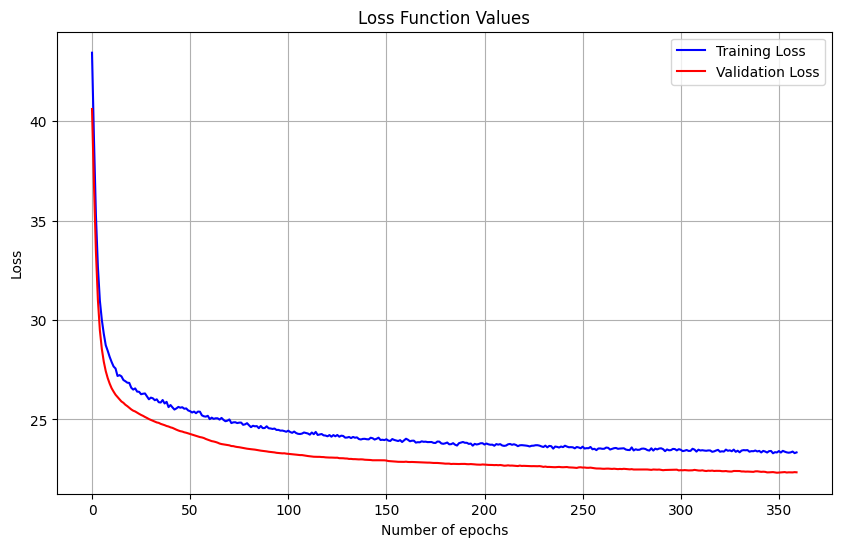

In [ ]:
# Plot the loss curve
model.plot_loss_curve()

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


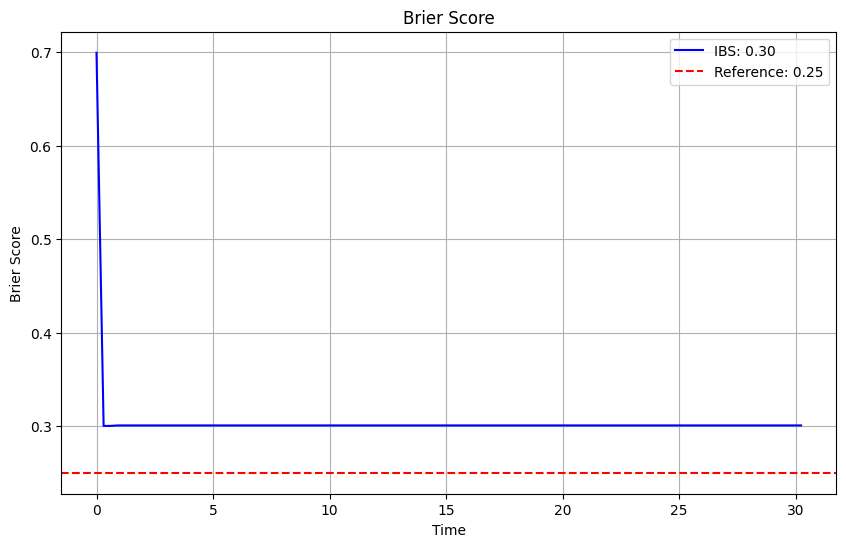

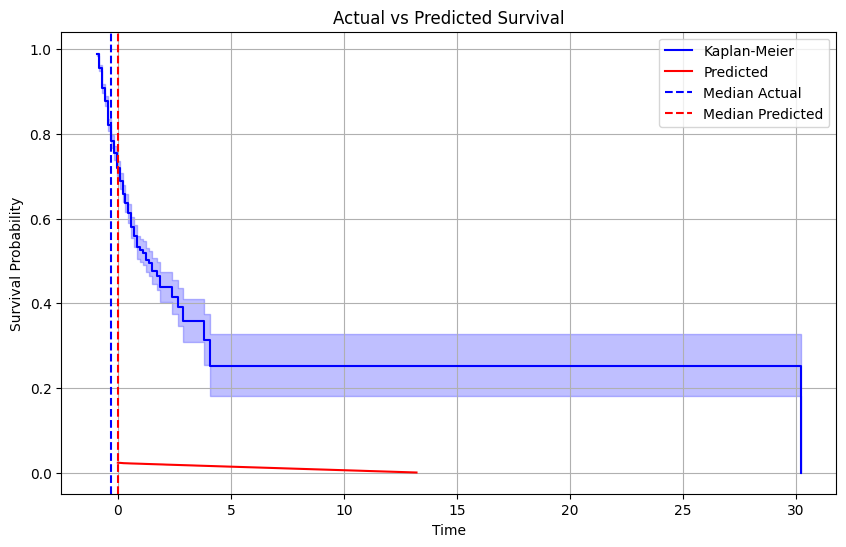

c-index: 0.5686739472245009, Brier score: 0.3026095186466577


In [ ]:
# Evaluate the model
c_index, brier_score = model.evaluate(test_data[X], test_data[T], test_data['SURVIVAL'] == 1) # Access the 'SURVIVAL' column and create a boolean array
print(f"c-index: {c_index}, Brier score: {brier_score}")

In [ ]:
# Make predictions (example)
density, Survival = model.predict(test_data[X].values[:5])
print(Survival)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


ValueError: too many values to unpack (expected 2)

In [ ]:
# Make predictions (example)
predictions = model.predict(test_data[X].values[:5])
density = predictions[0]  # Assuming density is the first element
Survival = predictions[1] # Assuming Survival is the second element
print(Survival)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
[9.99999881e-01 9.99936879e-01 2.25782208e-03 1.45890534e-01
 3.04242242e-02 5.91938477e-03 3.08844447e-02 2.60748006e-02
 6.39917910e-01 2.05064025e-02 8.65996256e-03 3.14136571e-03
 1.91181824e-02 6.98652640e-02 2.87930830e-03 6.52067482e-01
 2.63971388e-02 1.41350403e-02 2.42878706e-03 1.09587749e-03
 8.74856079e-04 6.35271193e-04 4.33518877e-03 2.05648452e-04
 6.52667950e-04 4.32136148e-01 4.11946297e-04 2.83808127e-04
 5.35250502e-03 1.60693959e-03 7.60046183e-04 4.22206614e-03
 3.20115745e-01 2.02972263e-01 5.93543937e-03 7.36575399e-04
 4.79432708e-03 3.02614528e-03 1.23186200e-03 9.95562761e-04
 5.27640921e-04 4.84089396e-04 6.67229411e-04 7.72504252e-04
 2.32554530e-03 3.76345910e-04 3.37814417e-04 6.34945754e-04
 9.09225782e-04 2.89633463e-04 9.93527472e-04 3.21468629e-04
 6.08886068e-04 3.08318250e-02 4.19459581e-01 8.49895179e-03
 3.78557742e-01 1.04972288e-01 6.53074458e-02 2.91225344e-01
 9.98914614e-03 2.77857725e-02 3.24497931e-03 2

In [ ]:
# To understand the structure of 'predictions', uncomment the line below
print(predictions)

[[9.99999881e-01 9.99936879e-01 2.25782208e-03 1.45890534e-01
  3.04242242e-02 5.91938477e-03 3.08844447e-02 2.60748006e-02
  6.39917910e-01 2.05064025e-02 8.65996256e-03 3.14136571e-03
  1.91181824e-02 6.98652640e-02 2.87930830e-03 6.52067482e-01
  2.63971388e-02 1.41350403e-02 2.42878706e-03 1.09587749e-03
  8.74856079e-04 6.35271193e-04 4.33518877e-03 2.05648452e-04
  6.52667950e-04 4.32136148e-01 4.11946297e-04 2.83808127e-04
  5.35250502e-03 1.60693959e-03 7.60046183e-04 4.22206614e-03
  3.20115745e-01 2.02972263e-01 5.93543937e-03 7.36575399e-04
  4.79432708e-03 3.02614528e-03 1.23186200e-03 9.95562761e-04
  5.27640921e-04 4.84089396e-04 6.67229411e-04 7.72504252e-04
  2.32554530e-03 3.76345910e-04 3.37814417e-04 6.34945754e-04
  9.09225782e-04 2.89633463e-04 9.93527472e-04 3.21468629e-04
  6.08886068e-04 3.08318250e-02 4.19459581e-01 8.49895179e-03
  3.78557742e-01 1.04972288e-01 6.53074458e-02 2.91225344e-01
  9.98914614e-03 2.77857725e-02 3.24497931e-03 2.03439649e-02
  2.4751

In [ ]:
print(density)

[9.99999881e-01 9.99936879e-01 2.25782208e-03 1.45890534e-01
 3.04242242e-02 5.91938477e-03 3.08844447e-02 2.60748006e-02
 6.39917910e-01 2.05064025e-02 8.65996256e-03 3.14136571e-03
 1.91181824e-02 6.98652640e-02 2.87930830e-03 6.52067482e-01
 2.63971388e-02 1.41350403e-02 2.42878706e-03 1.09587749e-03
 8.74856079e-04 6.35271193e-04 4.33518877e-03 2.05648452e-04
 6.52667950e-04 4.32136148e-01 4.11946297e-04 2.83808127e-04
 5.35250502e-03 1.60693959e-03 7.60046183e-04 4.22206614e-03
 3.20115745e-01 2.02972263e-01 5.93543937e-03 7.36575399e-04
 4.79432708e-03 3.02614528e-03 1.23186200e-03 9.95562761e-04
 5.27640921e-04 4.84089396e-04 6.67229411e-04 7.72504252e-04
 2.32554530e-03 3.76345910e-04 3.37814417e-04 6.34945754e-04
 9.09225782e-04 2.89633463e-04 9.93527472e-04 3.21468629e-04
 6.08886068e-04 3.08318250e-02 4.19459581e-01 8.49895179e-03
 3.78557742e-01 1.04972288e-01 6.53074458e-02 2.91225344e-01
 9.98914614e-03 2.77857725e-02 3.24497931e-03 2.03439649e-02
 2.47514341e-03 5.566521